Bandpass: 0.5–3.0 Hz @ fs=50.355 Hz | order 4

Processing: data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea\TDL010_voltage_apnea.csv
  Saved CSV → data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered\TDL010_voltage_apnea.csv


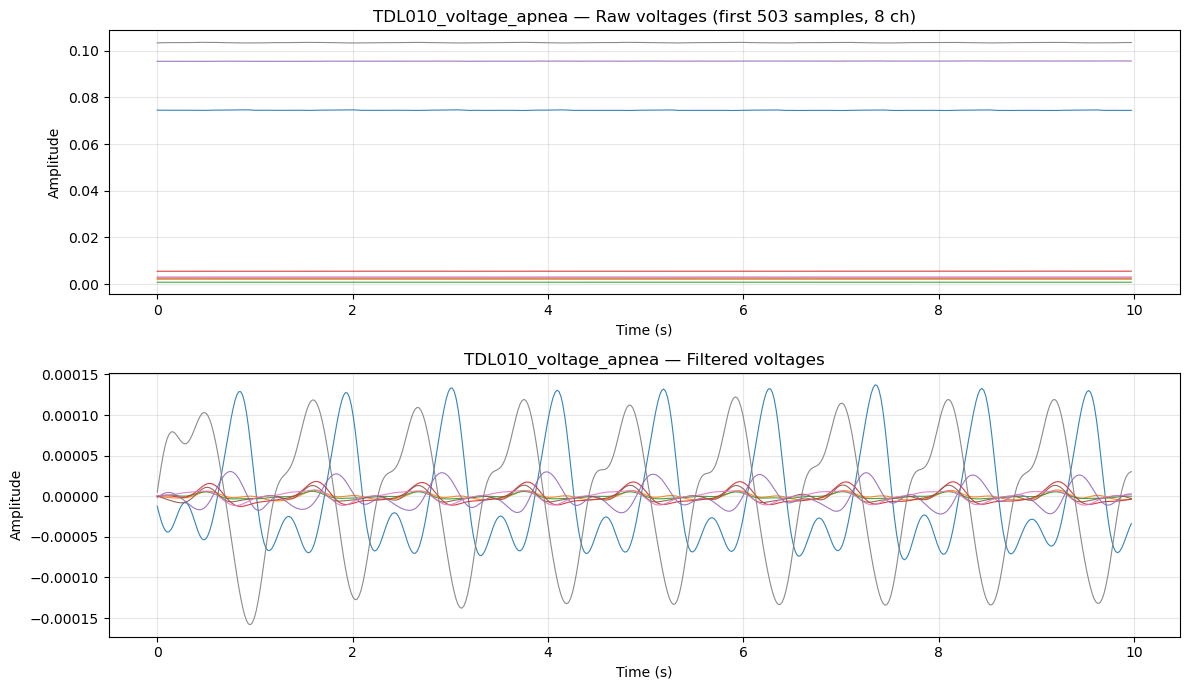

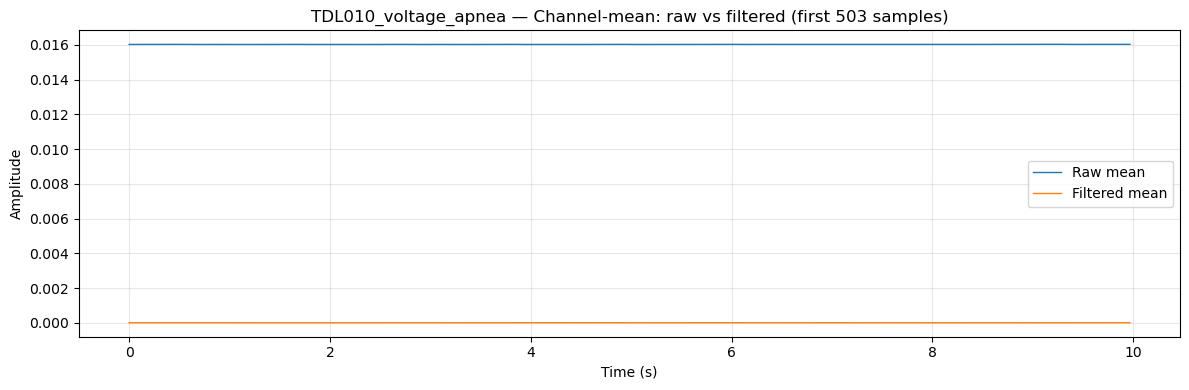


Processing: data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea\TDL012_voltage_apnea.csv
  Saved CSV → data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered\TDL012_voltage_apnea.csv


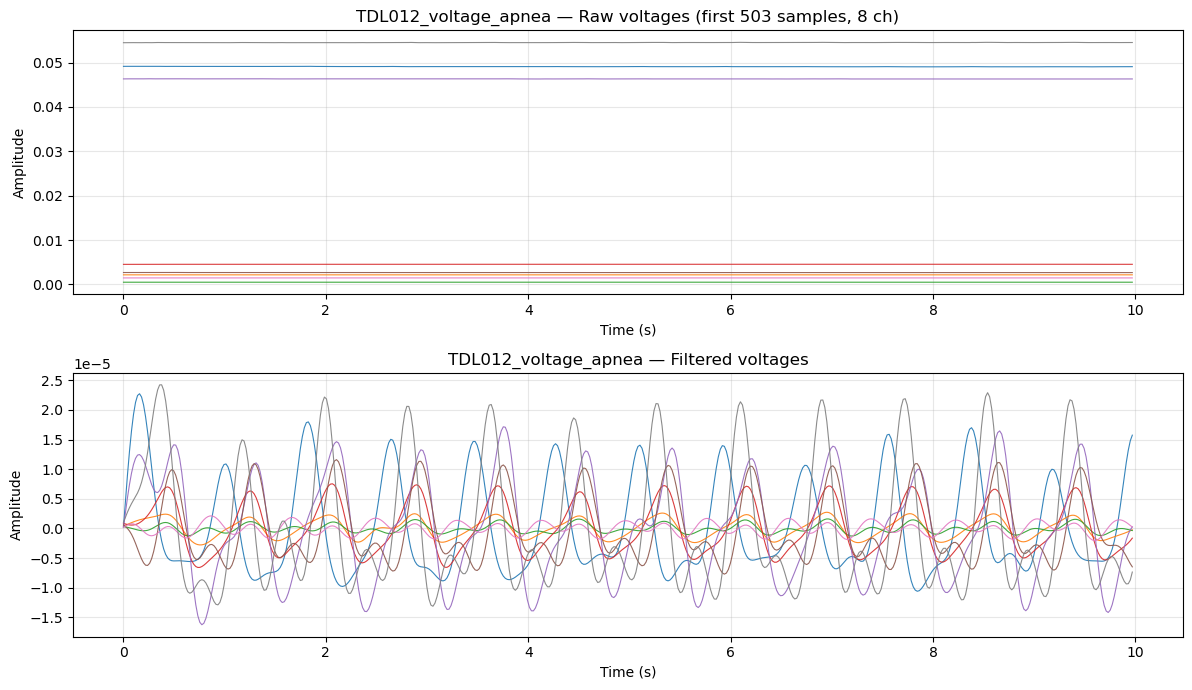

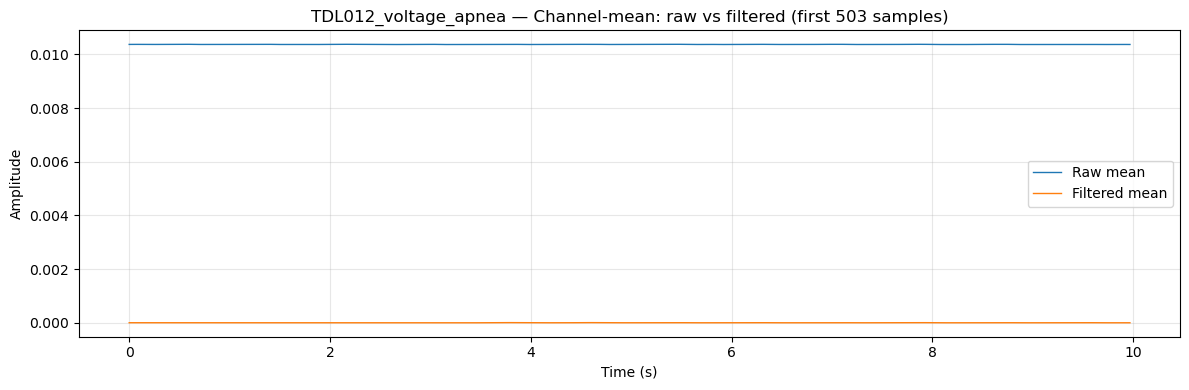


Processing: data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea\TDL013_voltage_apnea.csv
  Saved CSV → data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered\TDL013_voltage_apnea.csv


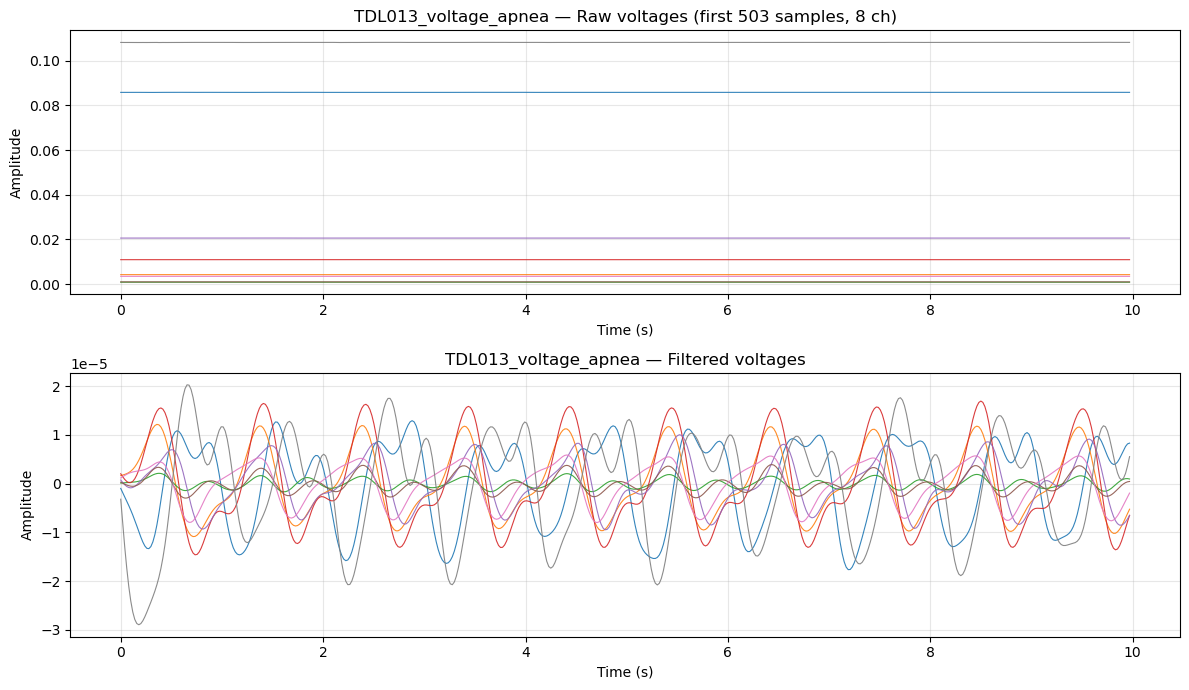

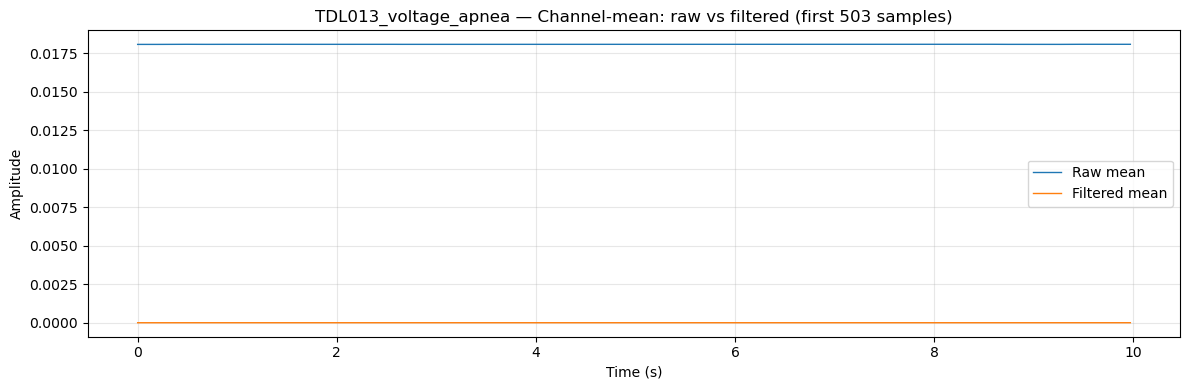


Processing: data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea\TDL014_voltage_apnea.csv
  Saved CSV → data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered\TDL014_voltage_apnea.csv


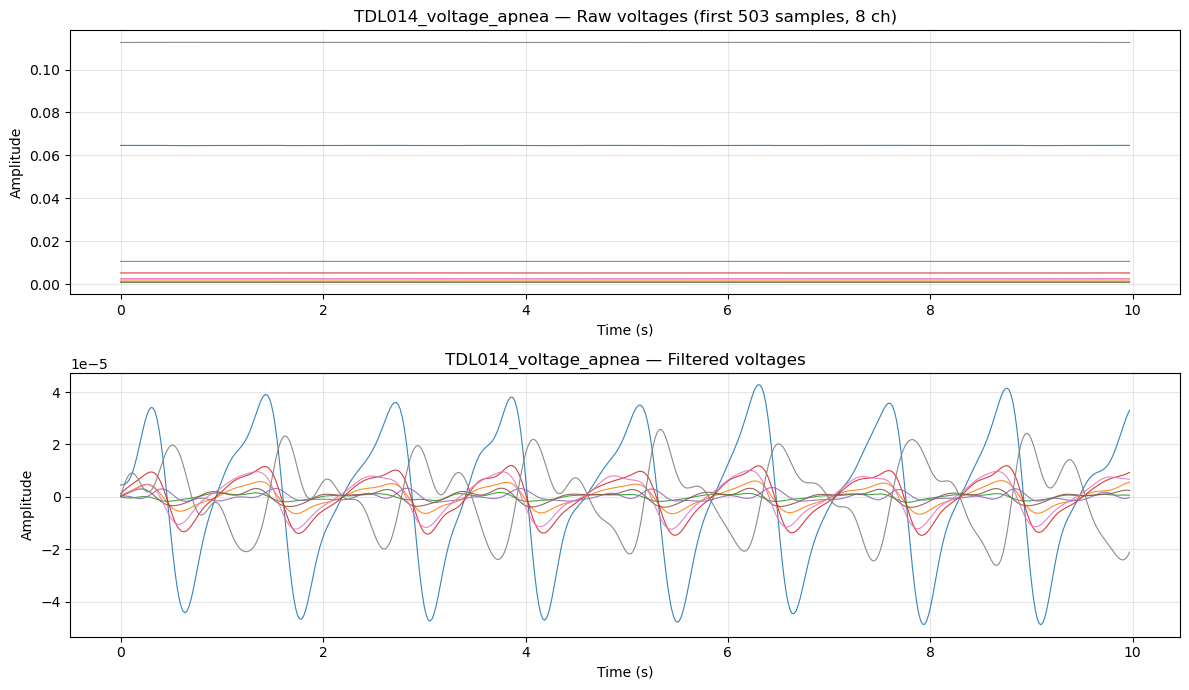

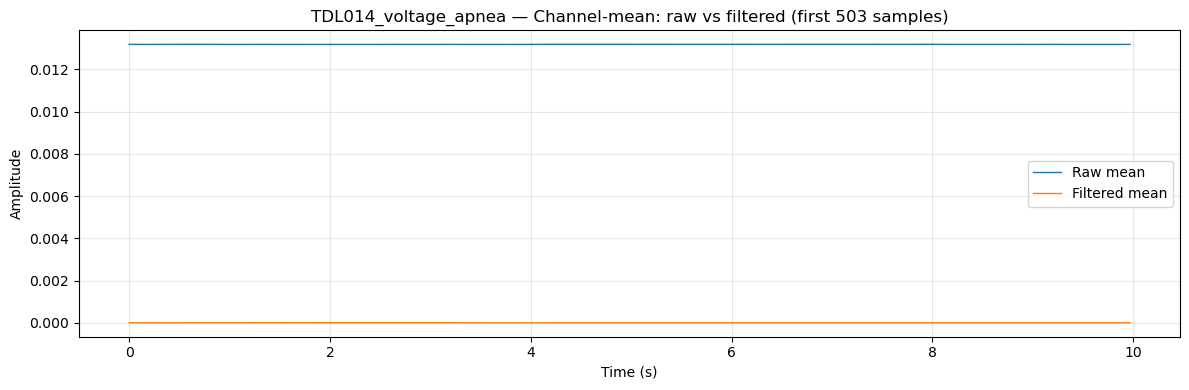


Processing: data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea\TDL015_voltage_apnea.csv
  Saved CSV → data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered\TDL015_voltage_apnea.csv


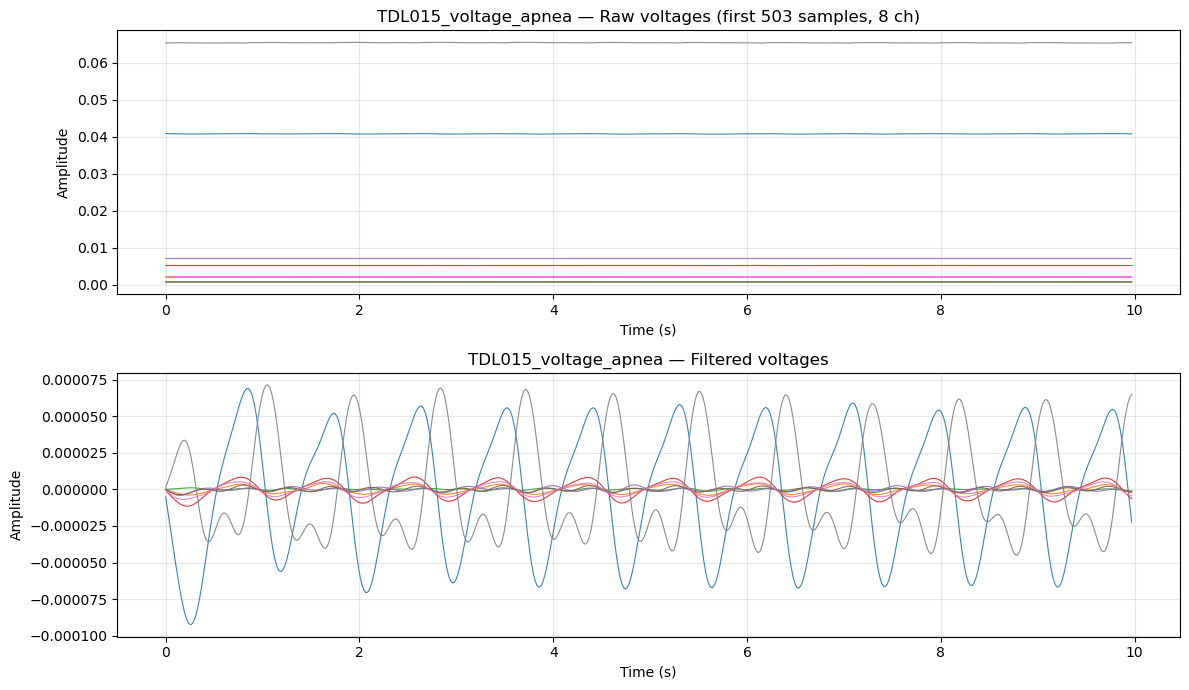

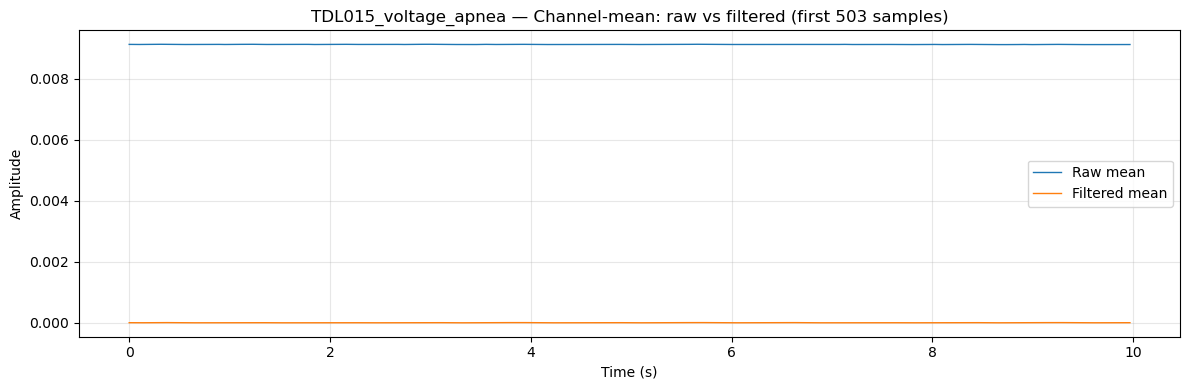


Processing: data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea\TDL016_voltage_apnea.csv
  Saved CSV → data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered\TDL016_voltage_apnea.csv


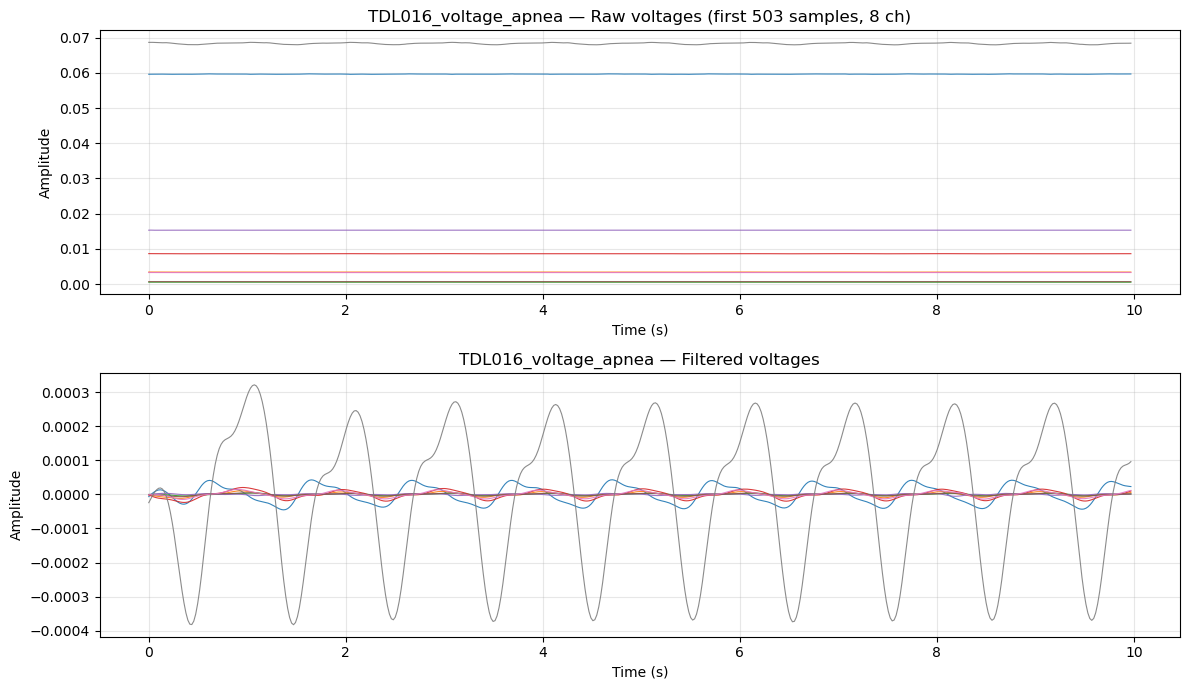

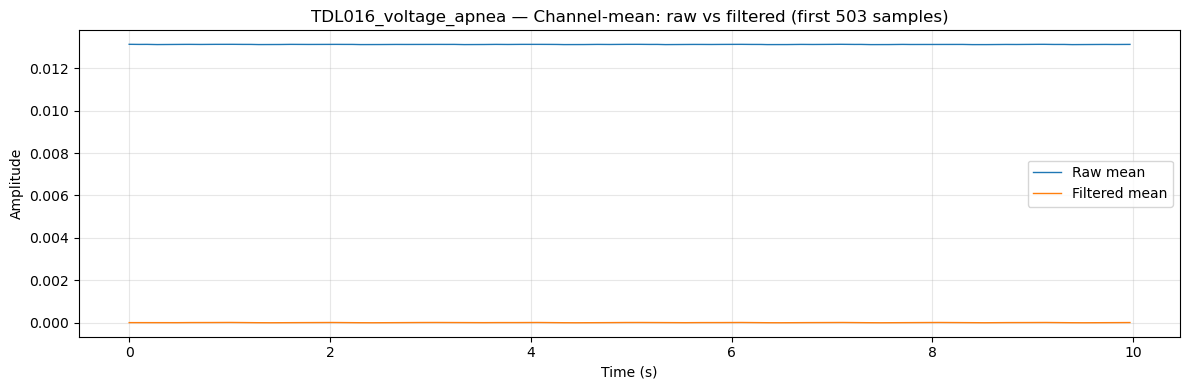


Done.


In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, detrend

# ============================== CONFIG ======================================
IN_FOLDER   = r"data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea"
OUT_FOLDER  = r"data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea filtered"

FS          = 50.355        # sampling rate (Hz)
LOWCUT      = 0.5           # bandpass low cut (Hz) - adjust if HR very low
HIGHCUT     = 3.0           # bandpass high cut (Hz) - raise if HR very high
ORDER       = 4             # Butterworth order (effective is doubled by filtfilt)

PLOT_SECONDS = 10           # show only the first N seconds per file
PLOT_CHANNELS = 8           # number of representative channels to overlay
# ============================================================================


def butter_bandpass_sos(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if not (0 < low < high < 1):
        raise ValueError(f"Bad band: low={lowcut} high={highcut} with fs={fs} (nyquist={nyq})")
    return butter(order, [low, high], btype="band", output="sos")


def apply_bandpass_matrix(df, lowcut, highcut, fs, order=4):
    """
    Vectorized band-pass on all columns, time on axis=0.
    Assumes no NaNs. Returns a DataFrame with same shape.
    """
    X = df.to_numpy(dtype=np.float32, copy=False)

    # too short for filtfilt padding? just de-mean and return
    if X.shape[0] < 60:
        X0 = X - np.mean(X, axis=0, keepdims=True)
        return pd.DataFrame(X0)

    # remove DC offset to reduce edge transients
    X = detrend(X, axis=0, type="constant")

    sos = butter_bandpass_sos(lowcut, highcut, fs, order=order)

    # safe padlen for sosfiltfilt (function of number of biquad sections)
    sections = sos.shape[0]
    padlen = min(int(6 * sections), X.shape[0] - 1)

    Y = sosfiltfilt(sos, X, axis=0, padlen=padlen)
    return pd.DataFrame(Y)


def _pick_channels(n_channels, k=8):
    """Pick k representative channels spread across the array."""
    k = min(k, n_channels)
    return np.unique(np.linspace(0, n_channels - 1, k, dtype=int))


def plot_before_after_inline(df_raw, df_filt, fs, max_seconds=10, channels_to_plot=8, title_prefix=""):
    """
    Display plots inline (no saving):
      1) Overlay of selected channels (raw vs filtered), first max_seconds
      2) Channel-mean trace (raw vs filtered), first max_seconds
    """
    Xr = df_raw.to_numpy(dtype=np.float32, copy=False)
    Xf = df_filt.to_numpy(dtype=np.float32, copy=False)
    n, m = Xr.shape
    nshow = min(n, int(max_seconds * fs))
    t = np.arange(nshow) / fs
    ch_idx = _pick_channels(m, channels_to_plot)

    # Figure 1: selected channels overlay
    plt.figure(figsize=(12, 7))
    plt.subplot(2, 1, 1)
    for j in ch_idx:
        plt.plot(t, Xr[:nshow, j], linewidth=0.8, alpha=0.9)
    plt.title(f"{title_prefix}Raw voltages (first {nshow} samples, {len(ch_idx)} ch)")
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    for j in ch_idx:
        plt.plot(t, Xf[:nshow, j], linewidth=0.8, alpha=0.9)
    plt.title(f"{title_prefix}Filtered voltages")
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Figure 2: channel-mean overlay (single trace)
    mean_raw = Xr[:nshow].mean(axis=1)
    mean_filt = Xf[:nshow].mean(axis=1)
    plt.figure(figsize=(12, 4))
    plt.plot(t, mean_raw, label="Raw mean", linewidth=1.0)
    plt.plot(t, mean_filt, label="Filtered mean", linewidth=1.0)
    plt.title(f"{title_prefix}Channel-mean: raw vs filtered (first {nshow} samples)")
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.show()


def main():
    os.makedirs(OUT_FOLDER, exist_ok=True)

    csv_files = glob.glob(os.path.join(IN_FOLDER, "*.csv"))
    if not csv_files:
        print("No CSV files found.")
        return

    print(f"Bandpass: {LOWCUT}–{HIGHCUT} Hz @ fs={FS} Hz | order {ORDER}")
    for fp in csv_files:
        print(f"\nProcessing: {fp}")
        df_raw = pd.read_csv(fp, header=None)

        # Ensure all numeric (fast fail if not)
        if not all(np.issubdtype(dt, np.number) for dt in df_raw.dtypes.values):
            raise ValueError(f"{fp}: non-numeric columns found (expected all numeric).")

        # Filter
        df_filt = apply_bandpass_matrix(df_raw, LOWCUT, HIGHCUT, FS, order=ORDER)

        # Save filtered CSV (keeps originals untouched)
        out_csv = os.path.join(OUT_FOLDER, os.path.basename(fp))
        df_filt.to_csv(out_csv, header=False, index=False)
        print(f"  Saved CSV → {out_csv}")

        # Inline plots (two figures per file)
        title_prefix = os.path.splitext(os.path.basename(fp))[0] + " — "
        plot_before_after_inline(
            df_raw, df_filt,
            fs=FS,
            max_seconds=PLOT_SECONDS,
            channels_to_plot=PLOT_CHANNELS,
            title_prefix=title_prefix
        )

    print("\nDone.")

if __name__ == "__main__":
    import glob  # local import to keep top tidy
    main()
